# Phase 2: Classification Prediction with Imbalanced Target

# Mary Donovan Martello

**Phase 1 of the credit card default project involved testing five binary classification models for predicting credit card defaults.  Phase 1 can be found:** [here](https://github.com/MaryDonovanMartello/Credit-Card-Default-Prediction)

**Phase 2 of the credit card default project includes (1) employing methodologies other than Principal Component Analysis to address multicollinearity and feature selection in an effort to be able to analyze individual factors that are significant for defaults, (2) testing multiple approaches to addressing an imbalanced target variable in a binary classification model, and (3) implementing deployment models to make actual predictions and convert the logistic regression coefficients to a risk score that can be used in making lending decisions.**

## Part 5:  Approach to Imbalance:  Oversample Training Data with GroupKFold

In [75]:
# import libraries

import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax
from numpy import where

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, average_precision_score, auc, precision_recall_curve, log_loss

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
#from imblearn.pipeline import Pipeline


#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')




### This notebook uses two datasets that were cleaned and prepared in the 1_EDA_Prep notebook.  One of the datasets replaces some of the original variables with the Months_Late engineered features and the second dataset replaces some of the original variables with both the Months_Late and Payment_Ratio engineered features.

In [2]:
# Load data into a dataframe

df1 = pd.read_csv('logDefaultRev1.csv')
df2 = pd.read_csv('logDefaultRev2.csv')

In [3]:
df1.head()

,default,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MONTHS_LATE
0,1,1,1,2,3.401197,10.819798,12.157764,11.451880,12.121908,12.185186,11.599122,12.815479,0.000000,7.901377,0.000000,7.707962,7.090910,0.000000,1.94591
1,1,1,2,2,3.401197,12.676079,12.318723,11.767754,12.289720,12.339830,11.875079,12.907014,7.824446,7.824446,0.000000,8.476580,7.783641,7.378384,1.94591
2,1,1,1,1,3.988984,12.206078,12.623996,12.257488,12.610621,12.657464,12.339112,13.100394,8.748464,8.612685,8.612685,8.612685,8.517393,8.517393,1.94591
3,0,2,2,2,3.295837,11.002117,12.311630,11.735957,12.285069,12.346786,11.826144,12.886411,0.000000,8.517393,7.828835,1.945910,8.006701,8.006701,1.94591
4,0,1,2,1,3.737670,12.542548,12.615709,12.246783,12.584776,12.658428,12.360976,13.100157,8.779711,0.000000,9.564863,9.605822,0.000000,8.517393,1.94591


In [4]:
df1.shape

(30000, 19)

In [5]:
df1.columns

Index(['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'MONTHS_LATE'],
      dtype='object')

In [6]:
colNames1 = ['AGE', 'LIMIT_BAL',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'MONTHS_LATE', 'SEX', 'EDUCATION', 'MARRIAGE']

In [7]:
#df1 subset

# separate into input and output columns (X variable for features and y for target variables)

X1s = df1.loc[:, ['MONTHS_LATE', 'LIMIT_BAL', 'AGE']] 
y1s = df1['default']

In [8]:
X1s.columns

Index(['MONTHS_LATE', 'LIMIT_BAL', 'AGE'], dtype='object')

In [9]:
colNames1s = ['MONTHS_LATE', 'LIMIT_BAL', 'AGE']

In [10]:
df2.head()

,default,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,MONTHS_LATE,PAYMENT_RATIO
0,1,1,1,2,3.401197,10.819798,1.94591,0.038110
1,1,1,2,2,3.401197,12.676079,1.94591,0.037397
2,1,1,1,1,3.988984,12.206078,1.94591,0.037338
3,0,2,2,2,3.295837,11.002117,1.94591,0.038758
4,0,1,2,1,3.737670,12.542548,1.94591,0.046396


In [11]:
df2.shape

(29130, 8)

In [12]:
df2.columns

Index(['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'MONTHS_LATE', 'PAYMENT_RATIO'],
      dtype='object')

In [13]:
colNames2 = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'MONTHS_LATE', 'PAYMENT_RATIO']

In [14]:
#df2 subset

# separate into input and output columns (X variable for features and y for target variables)

X2s = df2.loc[:, ['MONTHS_LATE', 'PAYMENT_RATIO',]] 
y2s = df2['default']

In [15]:
X2s.columns

Index(['MONTHS_LATE', 'PAYMENT_RATIO'], dtype='object')

In [16]:
colNames2s = ['MONTHS_LATE', 'PAYMENT_RATIO']

**Create feature dataframes for modeling.**

In [17]:
#df1

# use get_dummies method for encoding categorical variables only to create subsets

# convert categorical data to numbers 
#get the categorical data
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat1 = df1[cat_features]

# create dummy variable dataframe for categorical values 
dfDumm1 = pd.get_dummies(df_cat1)

# create a whole features dataset that can be used for train and validation data splitting
# combine the numerical features and the dummie features together
dfNum1 = df1.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'default'], axis = 1)
X1 = pd.concat([dfNum1, dfDumm1], axis=1, ignore_index=True)
# create a whole target dataset that can be used for train and validation data splitting
y1 =  df1['default']

In [18]:
X1.columns = colNames1

In [19]:
X1.shape

(30000, 18)

In [20]:
X1.head()

,AGE,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MONTHS_LATE,SEX,EDUCATION,MARRIAGE
0,3.401197,10.819798,12.157764,11.451880,12.121908,12.185186,11.599122,12.815479,0.000000,7.901377,0.000000,7.707962,7.090910,0.000000,1.94591,1,1,2
1,3.401197,12.676079,12.318723,11.767754,12.289720,12.339830,11.875079,12.907014,7.824446,7.824446,0.000000,8.476580,7.783641,7.378384,1.94591,1,2,2
2,3.988984,12.206078,12.623996,12.257488,12.610621,12.657464,12.339112,13.100394,8.748464,8.612685,8.612685,8.612685,8.517393,8.517393,1.94591,1,1,1
3,3.295837,11.002117,12.311630,11.735957,12.285069,12.346786,11.826144,12.886411,0.000000,8.517393,7.828835,1.945910,8.006701,8.006701,1.94591,2,2,2
4,3.737670,12.542548,12.615709,12.246783,12.584776,12.658428,12.360976,13.100157,8.779711,0.000000,9.564863,9.605822,0.000000,8.517393,1.94591,1,2,1


In [34]:
y1.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [21]:
#df2

# use get_dummies method for encoding categorical variables only to create subsets

# convert categorical data to numbers 
#get the categorical data
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat2 = df2[cat_features]

# create dummy variable dataframe for categorical values 
dfDumm2 = pd.get_dummies(df_cat2)

# create a whole features dataset that can be used for train and validation data splitting
# combine the numerical features and the dummie features together
dfNum2 = df2.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'default'], axis = 1)
X2 = pd.concat([dfNum2, dfDumm2], axis=1, ignore_index=True)
# create a whole target dataset that can be used for train and validation data splitting
y2 =  df2['default']

In [22]:
X2.shape

(29130, 7)

In [33]:
y2.value_counts()

0    22811
1     6319
Name: default, dtype: int64

In [23]:
X2.columns = colNames2

In [24]:
X2.head()

,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,MONTHS_LATE,PAYMENT_RATIO
0,3.401197,10.819798,1.94591,0.038110,1,1,2
1,3.401197,12.676079,1.94591,0.037397,1,2,2
2,3.988984,12.206078,1.94591,0.037338,1,1,1
3,3.295837,11.002117,1.94591,0.038758,2,2,2
4,3.737670,12.542548,1.94591,0.046396,1,2,1


**Split and scale data**

In [25]:
# separate data into training and test data
X1Train, X1Test, y1Train, y1Test = train_test_split(X1, y1, test_size =0.2, random_state=1)


In [26]:
# define the scaler
scaler = StandardScaler()
# fit and transform on the training dataset
scaler.fit_transform(X1Train)
# transform the test dataset
X1Test = scaler.transform(X1Test)

In [62]:
# separate data into training and test data
X2Train, X2Test, y2Train, y2Test = train_test_split(X2, y2, test_size =0.2, random_state=1)


In [63]:
# define the scaler
scaler = StandardScaler()
# fit and transform on the training dataset
scaler.fit_transform(X2Train)
# transform the test dataset
X2Test = scaler.transform(X2Test)

In [99]:
# separate data into training and test data
X1sTrain, X1sTest, y1sTrain, y1sTest = train_test_split(X1s, y1s, test_size =0.2, random_state=1)


In [100]:
# define the scaler
scaler = StandardScaler()
# fit and transform on the training dataset
scaler.fit_transform(X1sTrain)
# transform the test dataset
X1sTest = scaler.transform(X1sTest)

In [87]:
# separate data into training and test data
X2sTrain, X2sTest, y2sTrain, y2sTest = train_test_split(X2s, y2s, test_size =0.2, random_state=1)


In [88]:
# define the scaler
scaler = StandardScaler()
# fit and transform on the training dataset
scaler.fit_transform(X2sTrain)
# transform the test dataset
X2sTest = scaler.transform(X2sTest)

**Oversample Training Data Only**

Need a unique label for each record before resampling data for GroupKFold below.

In [28]:
# add a column to be used as an identifer for each row before oversampling - to be used for grouping row in cv
X1Train["cv_label"] = X1Train.index

In [64]:
# add a column to be used as an identifer for each row before oversampling - to be used for grouping row in cv
X2Train["cv_label"] = X2Train.index

In [101]:
# add a column to be used as an identifer for each row before oversampling - to be used for grouping row in cv
X1sTrain["cv_label"] = X1sTrain.index

In [89]:
# add a column to be used as an identifer for each row before oversampling - to be used for grouping row in cv
X2sTrain["cv_label"] = X2sTrain.index

**Oversample training data for each of 4 subsets of data**

In [30]:
# over sample the minority class
#from imblearn.over_sampling import SMOTE

#smote = SMOTE()
#X1TrainBal, y1TrainBal = smote.fit_resample(X1Train, y1Train)

from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X1TrainBal, y1TrainBal = oversample.fit_resample(X1Train, y1Train)

In [65]:
# over sample the minority class
#from imblearn.over_sampling import SMOTE


from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X2TrainBal, y2TrainBal = oversample.fit_resample(X2Train, y2Train)

In [102]:
# over sample the minority class
#from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X1sTrainBal, y1sTrainBal = oversample.fit_resample(X1sTrain, y1sTrain)

In [90]:
# over sample the minority class
#from imblearn.over_sampling import SMOTE


from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X2sTrainBal, y2sTrainBal = oversample.fit_resample(X2sTrain, y2sTrain)

Put oversampled data back into dataframes.

In [36]:
colNames3 = ['AGE', 'LIMIT_BAL',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'MONTHS_LATE', 'SEX', 'EDUCATION', 'MARRIAGE', 'cv_label']

In [66]:
colNames4 = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'MONTHS_LATE', 'PAYMENT_RATIO', 'cv_label']

In [80]:
colNames5 = ['MONTHS_LATE', 'LIMIT_BAL', 'AGE', 'cv_label']

In [81]:
colNames6 = ['MONTHS_LATE', 'PAYMENT_RATIO', 'cv_label']

In [37]:
X1TrainBal = pd.DataFrame(data=X1TrainBal, columns = colNames3)

In [67]:
X2TrainBal = pd.DataFrame(data=X2TrainBal, columns = colNames4)

In [103]:
X1sTrainBal = pd.DataFrame(data=X1sTrainBal, columns = colNames5)

In [91]:
X2sTrainBal = pd.DataFrame(data=X2sTrainBal, columns = colNames6)

Need the id for each row for the grouping in the cross-validation below

In [47]:
# need the id for each row for the grouping in the cross-validation below
cv_labels = X1TrainBal['cv_label']

In [68]:
# need the id for each row for the grouping in the cross-validation below
cv_labels2 = X2TrainBal['cv_label']

In [104]:
# need the id for each row for the grouping in the cross-validation below
cv_labels3 = X1sTrainBal['cv_label']

In [92]:
# need the id for each row for the grouping in the cross-validation below
cv_labels4 = X2sTrainBal['cv_label']

Drop the unique label column added for oversampling before modeling.

In [51]:
# need to take out the column added to get an id for each row for grouping before cross-validation and training the model
X1TrainBal = X1TrainBal.drop(['cv_label'], axis=1)

In [69]:
# need to take out the column added to get an id for each row for grouping before cross-validation and training the model
X2TrainBal = X2TrainBal.drop(['cv_label'], axis=1)

In [105]:
# need to take out the column added to get an id for each row for grouping before cross-validation and training the model
X1sTrainBal = X1sTrainBal.drop(['cv_label'], axis=1)

In [93]:
# need to take out the column added to get an id for each row for grouping before cross-validation and training the model
X2sTrainBal = X2sTrainBal.drop(['cv_label'], axis=1)

**Tune Logistic Regression models and use GroupKFold for cross-validation.  GroupKFold keeps overbalanced data in training folds only.**

In [57]:
lrGroup= LogisticRegression()
params = {'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1', 'l2']}

group = cv_labels 
gkf = GroupKFold().split(X1TrainBal, y1TrainBal, group)
lr_grid=GridSearchCV(lrGroup, params, verbose=2,
          cv=gkf, scoring={'avr': make_scorer(recall_score, needs_proba=False),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, 
                    refit='avr', n_jobs = -1)


In [70]:
lrGroup= LogisticRegression()
params = {'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1', 'l2']}

group2 = cv_labels2
gkf2 = GroupKFold().split(X2TrainBal, y2TrainBal, group2)
lr_grid2=GridSearchCV(lrGroup, params, verbose=2,
          cv=gkf2, scoring={'avr': make_scorer(recall_score, needs_proba=False),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, 
                    refit='avr', n_jobs = -1)

In [106]:
lrGroup= LogisticRegression()
params = {'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1', 'l2']}

group3 = cv_labels3 
gkf3 = GroupKFold().split(X1sTrainBal, y1sTrainBal, group3)
lr_grid1s=GridSearchCV(lrGroup, params, verbose=2,
          cv=gkf3, scoring={'avr': make_scorer(recall_score, needs_proba=False),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, 
                    refit='avr', n_jobs = -1)


In [94]:
lrGroup= LogisticRegression()
params = {'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1', 'l2']}

group4 = cv_labels4
gkf4 = GroupKFold().split(X2sTrainBal, y2sTrainBal, group4)
lr_grid2s=GridSearchCV(lrGroup, params, verbose=2,
          cv=gkf4, scoring={'avr': make_scorer(recall_score, needs_proba=False),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, 
                    refit='avr', n_jobs = -1)

**Fit model for 4 different subsets of data**

In [58]:
# X1 df
lr_grid.fit(X1TrainBal, y1TrainBal)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 22.9min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001F70FE26DC8>,
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [71]:
# X2 df
lr_grid2.fit(X2TrainBal, y2TrainBal)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   50.4s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001F7122A31C8>,
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [107]:
# X1s df subset
lr_grid1s.fit(X1sTrainBal, y1sTrainBal)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.9s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001F716013648>,
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [95]:
# X2s df df
lr_grid2s.fit(X2sTrainBal, y2sTrainBal)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.5s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001F715F82548>,
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

**Evaluate Predictions**

<AxesSubplot:>

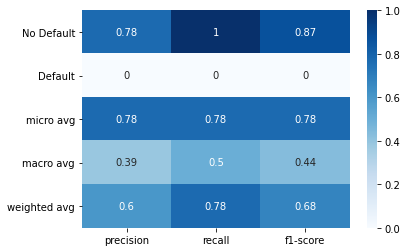

In [60]:
# predictions df1
y1Pred = lr_grid.predict(X1Test)

lrCR = classification_report(y1Test, y1Pred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR).iloc[:-1, :].T, annot=True, cmap="Blues")

In [61]:
lrCR

{'No Default': {'precision': 0.7765,
  'recall': 1.0,
  'f1-score': 0.8741908246552209,
  'support': 4659},
 'Default': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1341},
 'micro avg': {'precision': 0.7765,
  'recall': 0.7765,
  'f1-score': 0.7765,
  'support': 6000},
 'macro avg': {'precision': 0.38825,
  'recall': 0.5,
  'f1-score': 0.43709541232761046,
  'support': 6000},
 'weighted avg': {'precision': 0.60295225,
  'recall': 0.7765,
  'f1-score': 0.678809175344779,
  'support': 6000}}

<AxesSubplot:>

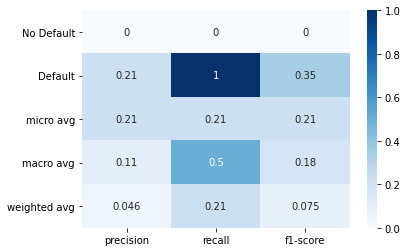

In [73]:
# predictions df2
y2Pred = lr_grid2.predict(X2Test)

lrCR2 = classification_report(y2Test, y2Pred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR2).iloc[:-1, :].T, annot=True, cmap="Blues")

In [74]:
lrCR2

{'No Default': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 4580},
 'Default': {'precision': 0.2138688637143838,
  'recall': 1.0,
  'f1-score': 0.35237556561085975,
  'support': 1246},
 'micro avg': {'precision': 0.2138688637143838,
  'recall': 0.2138688637143838,
  'f1-score': 0.2138688637143838,
  'support': 5826},
 'macro avg': {'precision': 0.1069344318571919,
  'recall': 0.5,
  'f1-score': 0.17618778280542988,
  'support': 5826},
 'weighted avg': {'precision': 0.04573989086648166,
  'recall': 0.2138688637143838,
  'f1-score': 0.07536216181790788,
  'support': 5826}}

<AxesSubplot:>

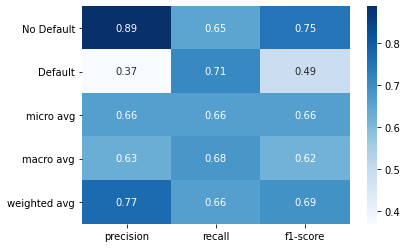

In [109]:
# predictions df1 subset 
y1sPred = lr_grid1s.predict(X1sTest)

lrCR1s = classification_report(y1sTest, y1sPred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR1s).iloc[:-1, :].T, annot=True, cmap="Blues")

In [110]:
lrCR1s

{'No Default': {'precision': 0.8870354111793971,
  'recall': 0.6505687915861773,
  'f1-score': 0.7506191183754334,
  'support': 4659},
 'Default': {'precision': 0.3697251258226868,
  'recall': 0.7121551081282624,
  'f1-score': 0.4867482161060143,
  'support': 1341},
 'micro avg': {'precision': 0.6643333333333333,
  'recall': 0.6643333333333333,
  'f1-score': 0.6643333333333333,
  'support': 6000},
 'macro avg': {'precision': 0.628380268501042,
  'recall': 0.6813619498572199,
  'f1-score': 0.6186836672407239,
  'support': 6000},
 'weighted avg': {'precision': 0.7714165624021724,
  'recall': 0.6643333333333333,
  'f1-score': 0.6916439717182182,
  'support': 6000}}

<AxesSubplot:>

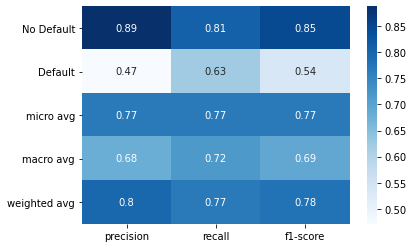

In [97]:
# predictions
y2sPred = lr_grid2s.predict(X2sTest)

lrCR2s = classification_report(y2sTest, y2sPred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR2s).iloc[:-1, :].T, annot=True, cmap="Blues")

In [98]:
lrCR2s

{'No Default': {'precision': 0.8880901030433741,
  'recall': 0.8091703056768559,
  'f1-score': 0.8467953844396205,
  'support': 4580},
 'Default': {'precision': 0.47126436781609193,
  'recall': 0.6252006420545746,
  'f1-score': 0.5374266988616764,
  'support': 1246},
 'micro avg': {'precision': 0.7698249227600412,
  'recall': 0.7698249227600412,
  'f1-score': 0.7698249227600412,
  'support': 5826},
 'macro avg': {'precision': 0.679677235429733,
  'recall': 0.7171854738657153,
  'f1-score': 0.6921110416506484,
  'support': 5826},
 'weighted avg': {'precision': 0.7989440566834027,
  'recall': 0.7698249227600412,
  'f1-score': 0.7806310551862531,
  'support': 5826}}